# El objetivo de este notebook es calcular el Bispectrum 1D usando el bosque de Ly-$\alpha$.

Importar modulos

In [30]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import fitsio 
import sys
from scipy.fftpack import fft
from glob import glob
#sys.path.append('/home/rodrigo/Documentos/env_pru/empca/') # solo si se usa para obtener el continuum flux, pero 
                                                            # en DR9 ya viene el continuum flux.
#import empca
%matplotlib inline
#%pylab inline

Se requerirá de una función que haga una interpolación. Esta función se obtuvo de [desispec](https://github.com/desihub/desispec).

In [3]:
def resample_flux(xout, x, flux, ivar=None, extrapolate=False):
    if ivar is None:
        return _unweighted_resample(xout, x, flux, extrapolate=extrapolate)
    else:
        if extrapolate :
            raise ValueError("Cannot extrapolate ivar. Either set ivar=None and extrapolate=True or the opposite")
        a = _unweighted_resample(xout, x, flux*ivar, extrapolate=False)
        b = _unweighted_resample(xout, x, ivar, extrapolate=False)
        mask = (b>0)
        outflux = np.zeros(a.shape)
        outflux[mask] = a[mask] / b[mask]
        dx = np.gradient(x)
        dxout = np.gradient(xout)
        outivar = _unweighted_resample(xout, x, ivar/dx)*dxout
        
        return outflux, outivar

def _unweighted_resample(output_x,input_x,input_flux_density, extrapolate=False) :
    
    # shorter names
    ix=input_x
    iy=input_flux_density
    ox=output_x

    # boundary of output bins
    bins=np.zeros(ox.size+1)
    bins[1:-1]=(ox[:-1]+ox[1:])/2.
    bins[0]=1.5*ox[0]-0.5*ox[1]     # = ox[0]-(ox[1]-ox[0])/2
    bins[-1]=1.5*ox[-1]-0.5*ox[-2]  # = ox[-1]+(ox[-1]-ox[-2])/2
    
    tx=bins.copy()
    if not extrapolate :
        # note we have to keep the array sorted here because we are going to use it for interpolation
        ix = np.append( 2*ix[0]-ix[1] , ix)
        iy = np.append(0.,iy)
        ix = np.append(ix, 2*ix[-1]-ix[-2])
        iy = np.append(iy, 0.)

    ty=np.interp(tx,ix,iy)
    
    #  add input nodes which are inside the node array
    k=np.where((ix>=tx[0])&(ix<=tx[-1]))[0]
    if k.size :
        tx=np.append(tx,ix[k])
        ty=np.append(ty,iy[k])
        
    # sort this node array
    p = tx.argsort()
    tx=tx[p]
    ty=ty[p]
    
    trapeze_integrals=(ty[1:]+ty[:-1])*(tx[1:]-tx[:-1])/2.
    
    trapeze_centers=(tx[1:]+tx[:-1])/2.
    binsize = bins[1:]-bins[:-1]

    if np.any(binsize<=0)  :
        raise ValueError("Zero or negative bin size")
    
    return np.histogram(trapeze_centers, bins=bins, weights=trapeze_integrals)[0] / binsize

In [4]:
fdir = '/home/rodrigo/Documentos/maestria/ultimo_año/datos_boss_dr9/BOSSLyaDR9_cat.fits'
DM = fitsio.FITS(fdir)
fm = fitsio.read(fdir,'BOSSLyaDR9_cat')
#fm.dtype.descr

Se deben leer los espectros medidos en cada píxel y almacenarlos en una única matriz que nos lleve a la dirrección donde se encuentran los archivos. Esta vez se hará para un bin en corrimiento al rojo de tamaño 0.2. 

In [5]:
mask = (fm['Z_VI'] > 2.8) & (fm['Z_VI'] < 3.0)
plate = fm['PLATE'][mask]
mjd = fm['MJD'][mask]
fiber = fm['FIBERID'][mask]
RA = fm['RA'][mask]
DEC = fm['DEC'][mask]
z_vi = fm['Z_VI'][mask]
pixels = []
for i in range(plate.size):
    pixels.append('BOSSLyaDR9_spectra/{}/speclya-{}-{}-{}.fits'.format(plate[i],plate[i],mjd[i],str(fiber[i]).zfill(4)))
pixels = np.array(pixels)

In [6]:
print('long. plates = {} \nlong. mjds = {} \nlong. fibers = {} \nnumber of redshifts = {}'.format(len(plate),len(mjd),len(fiber),len(z_vi)))

long. plates = 4990 
long. mjds = 4990 
long. fibers = 4990 
number of redshifts = 4990


Leer y extraer el la longitud de onda (y madarlo al marco en reposo), flujo y el espectro continuo para los primeros 2,000 espectros. Además sólo se va a considerar la región del bosque de Ly-$\alpha$ 

In [7]:
waverf = []
continuos = []
flujos = []
ivar = []
for i in range(len(z_vi))[:2000]:
    specfile = '/home/rodrigo/Documentos/maestria/ultimo_año/datos_boss_dr9/{}'.format(pixels[i])
    spi = fitsio.read(specfile)
    wave = 10**(spi['LOGLAM'])
    wave_rf = wave/(1+z_vi[i])
    maska = (wave_rf > 1040) & (wave_rf < 1200) # región del bosque de Lyalpha
    waverf.append(wave_rf[maska])
    continuos.append(spi['CONT'][maska])
    flujos.append(spi['FLUX'][maska])
    ivar.append(spi['IVAR'][maska])

Ahora se deben normalizar los espectros, para esto se tomará la integral de los espectros en el rango completo del bosque.

In [8]:
lmin=1040.0
lmax=1199.0

integral = []
continuo_nor = []
flux_nor = []
ivar_nor = []
for i in range(len(waverf)):
    sum1=0
    sum2=0
    flag=0
    for j in range(len(waverf[i])):
        if lmin <= waverf[i][j] < lmax :
            sum1+=(continuos[i][j])*(waverf[i][j+1]-waverf[i][j])
            sum2+=(flujos[i][j])*(waverf[i][j+1]-waverf[i][j])
        else:
            break
    integral.append(sum1)
    continuo_nor.append(continuos[i]/sum1)
    flux_nor.append(flujos[i]/sum2)
    ivar_nor.append((ivar[i])*((sum2)**2))

Ya se tiene a los espectros (como a los continuos) normalizados.

### Lo que sigue ahora es contruir el campo de sobredensidades de flujo, es decir, las deltas de flujo.

Recordemos la definición de las deltas.

\begin{equation}
\delta(\lambda) = \frac{F(\lambda)}{\overline{F}(\lambda)} - 1 = \frac{f(\lambda)}{C(\lambda)\overline{F}(\lambda)} - 1,
\end{equation}

donde $F(\lambda) = \dfrac{f(\lambda)}{C(\lambda)}$ es el flujo transmitido o transmisión y $f(\lambda)$ el flujo medido y $C(\lambda)$ es el espectro continuo de los QSO.

Primero debemos concatenar todos los flujos, continuos y longitudes de onda en una sola matriz.

Se debe contruir una nueva longitud de onda para poder hacer la interpolación, además de hacer que todos los espectros tengan el mismo $\Delta \lambda$, que es crucial para calcular el 1D Power Spectrum.

In [9]:
print('Anchura aproxinada Δλ de los espectros base = ',waverf[1][1]-waverf[1][0])

Anchura aproxinada Δλ de los espectros base =  0.23925781


In [10]:
CRVAL1 = 2.6534
CDELT1 = 0.0001
NBLL   = 13637
wwave = 10**(CRVAL1+np.arange(NBLL)*CDELT1)
masw = (wwave > 1040) & (wwave < 1200)
wwave = wwave[masw]

Interpolación

In [11]:
dflux  = np.zeros((len(flux_nor), wwave.size))
divar  = np.zeros((len(flux_nor), wwave.size))
dconti  = np.zeros((len(flux_nor), wwave.size))

for i in range(len(flux_nor)):
    dflux[i], divar[i] = resample_flux(wwave,waverf[i],flux_nor[i], ivar[i]) # interpolation 
    dconti[i] = resample_flux(wwave,waverf[i],continuo_nor[i])

In [12]:
 print('Shape wave            = {} \nlong. Shape flujo     = {} \nlong. Shape continuo  = {} \nlong. Shape ivar      = {}'.format(wwave.shape,dflux.shape, dconti.shape, divar.shape))

Shape wave            = (621,) 
long. Shape flujo     = (2000, 621) 
long. Shape continuo  = (2000, 621) 
long. Shape ivar      = (2000, 621)


In [13]:
divar[divar<0.] = 0              #
w = sp.sum(divar,axis=0)>0.      #
wwave = wwave[w]                 # For the noise.
dflux = dflux[:,w]               #
divar = divar[:,w]               #
dconti = dconti[:,w]             #
divar[divar>100.] = 100.         #

Procedamos a calcular las $\delta$

In [14]:
def deltas(dflujo, dcont):
    F = np.zeros((dflux.shape))              # Transmision
    for i in range(len(dflujo)):
        F[i] = dflujo[i]/dcont[i]
    Fmean = sp.average(F, axis = 0)          #Transmision promedio  
    delta = F/Fmean - 1                      #Delta
    Dmean = sp.average(delta, axis = 0)
    return F, Fmean, delta, Dmean

In [15]:
T, Tprom, delt, deltprom = deltas(dflux,dconti)

Veamos la transmisiones y la transmisión promedio

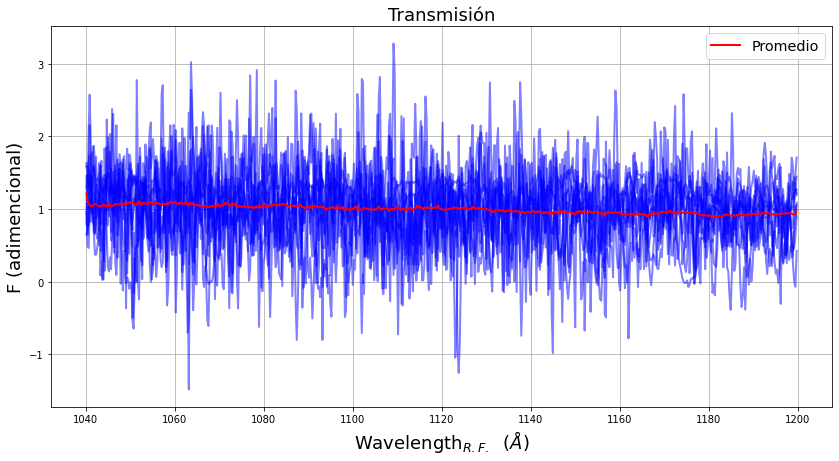

In [16]:
plt.figure(figsize=(14,7))
plt.title('Transmisión',fontsize = 18)
for k in range(len(waverf))[:10]:
    plt.plot(wwave,T[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(wwave,Tprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('F (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Finalmente veamos las deltas y la delta promedio.

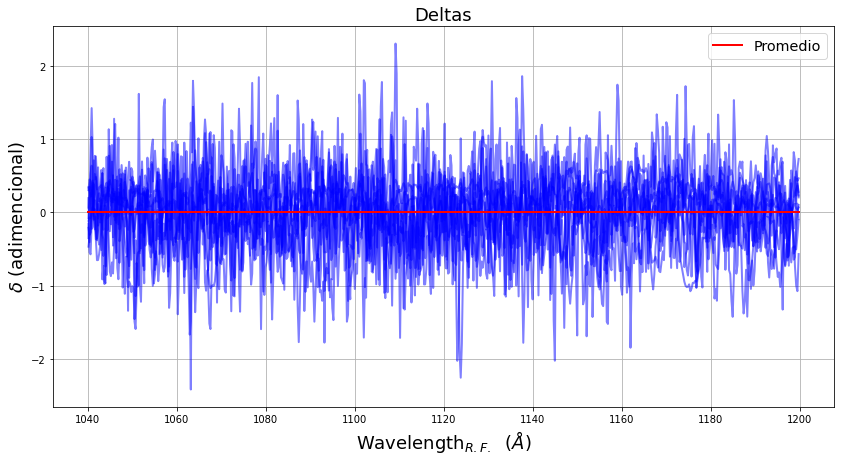

In [17]:
plt.figure(figsize=(14,7))
plt.title('Deltas',fontsize = 18)
for k in range(len(waverf))[:10]:
    plt.plot(wwave,delt[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(wwave,deltprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('$\delta$ (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Como se puede ver el promedio de $\delta$ está sobre cero y las diferencias se ven a orden $10^{-15}$.

Dado que  $\Delta\log(\lambda) = 1 × 10^{-4}$ e igualmente espaciada para todos los pixels (entiendase esta vez como separación entre longitudes de onda). Lo importante es que esten igualmente espaciadas.

In [18]:
logwave = np.log10(wwave)
print('Δlog(λ) = ', logwave[1]-logwave[0])

Δlog(λ) =  9.999999999976694e-05


Mientras que la diferencia de velocidades entre pixels o velocidad relativa de las líneas de absorción (como función de longitudes de onda).

\begin{equation}
\Delta v (\lambda) = c\Delta z = c \dfrac{\Delta \lambda}{\lambda} = c \Delta[Ln(\lambda)] = c Ln(10)\Delta[\log(\lambda)],
\end{equation}
donde $c$ es la velocidad de la luz. c = 300,000 km/s.

In [19]:
from scipy.constants import speed_of_light as speed_light
print('c = ', speed_light,'m/s')
Dv = (speed_light/1000.0)*np.log(10)*(logwave[1]-logwave[0])
#Dv = (speed_light/1000.0)*np.log(10)*len(delt[0])*(logwave[1]-logwave[0])
print('Δv(λ) = ', Dv,'km/s')

c =  299792458.0 m/s
Δv(λ) =  69.02976447812347 km/s


Ahora se debe cambiar $\delta(\lambda) \rightarrow \delta(\Delta v)$ 

## Calcular el 1D Power Spectrum

Lo que se debe hacer es aplicar la transformada de Fourier al campo $\delta(\Delta v)$, donde el vector de onda será $k = \dfrac{2\pi}{\Delta v}$ cuyas unidades son $(km/s)^{-1}$.

In [26]:
def pkraw(vel, deltasv):
    ####
    nb_pixels = len(deltasv[0])
    nbin_fft = nb_pixels//2 + 1
    Pk = np.zeros((len(deltasv),nbin_fft))
    delkd = []
    for i in range(len(deltasv)):
        #Hacer FFT
        fftdelta = fft(deltasv[i])
        #Calcular 1DPS
        fftdelta = fftdelta[:nbin_fft]
        Pk[i] = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
        delkd.append(fftdelta)
    deltk = np.vstack(delkd)
    Pkm = sp.average(Pk, axis=0)
    #std = np.std(Pk, axis = 0 ) 
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pkm, Pk, deltk

In [75]:
def pk1noise(vel, deltasvv):
    ####
    nb_pixels = len(deltasvv)
    nbin_fft = nb_pixels//2 + 1
    #Hacer FFT
    fftdelta = fft(deltasvv)
    #Calcular 1DPS
    fftdelta = fftdelta[:nbin_fft]
    Pk = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pk, fftdelta

In [83]:
def pknoise(vel,noise):
    ####
    nb_pixels = len(noise[0])
    nbin_fft = nb_pixels//2 + 1
    pknois = np.zeros((len(noise),nbin_fft))
    delkiv = []
    #
    for i in range(len(noise)):
        nb_noise_exp = 10
        Pk = np.zeros(nbin_fft)
        delknoise = []
        err = np.zeros(nb_pixels)
        noises = noise[i]
        w = noises>0
        err[w] = 1.0/np.sqrt(noises[w])
        for j in range(nb_noise_exp):
            delta_exp= np.zeros(nb_pixels)
            delta_exp[w] = sp.random.normal(0.,err[w])
            j,Pk_exp, deltasnoise = pk1noise(vel,delta_exp) #k_exp unused, but needed
            Pk += Pk_exp
            delknoise.append(deltasnoise)
        Pk /= float(nb_noise_exp)
        delknoise = np.vstack(delknoise)
        delknoise = np.sum(delknoise,axis=0)/float(nb_noise_exp)
        pknois[i] = Pk
        delkiv.append(delknoise)
    Pknoises = np.average(pknois, axis=0)
    delkiv = np.vstack(delkiv)
    delknoises = np.average(delkiv, axis=0)
    return Pknoises, pknois, delkiv

El espectro de potencias 1D se expresa como:

\begin{equation}
P_{1D}(k) = \langle \dfrac{P^{raw}(k) - P^{noise}(k)}{W^{2}(k,R,\Delta v)} \rangle,
\end{equation}

donde $R$ es la resolución del espectrógrafo, $P^{raw}(k) = |F(\delta(\Delta v))|^{2}$ y $P^{noise}(k) = |F(n(\Delta v))|^{2}$. W es una función ventana correspondiente a la respuesta espectral del espectrógrafo, cuya forma es:

\begin{equation}
W(k,R,\Delta v) = \exp(-\dfrac{(kR)^2}{2})× \dfrac{\sin(k\Delta v / 2)}{k\Delta v / 2}
\end{equation}

In [31]:
k1d, Pkraw_mean, Pkraws, Pdelk = pkraw(Dv, delt)

In [84]:
Pk_noise_mean, Pknoises, Dkiv = pknoise(Dv, divar)

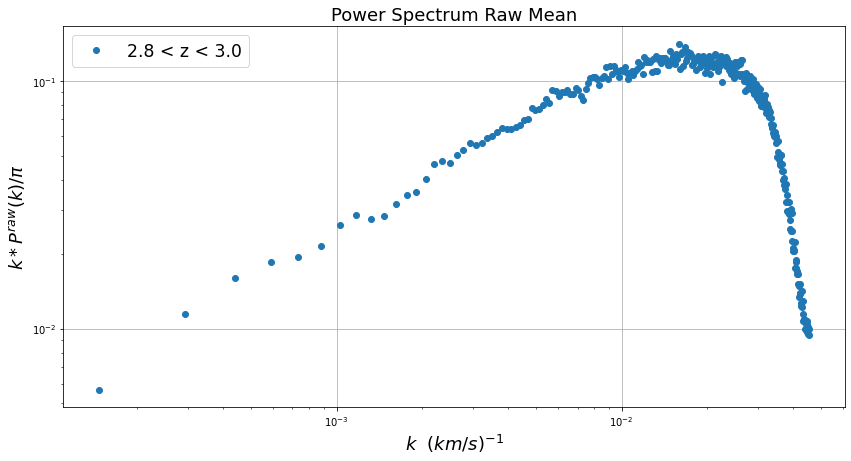

In [34]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Raw Mean',fontsize = 18)
plt.plot(k1d,k1d*Pkraw_mean/np.pi,'o', label = '2.8 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{raw}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [35]:
Preal = np.average(Pdelk.real,axis=0)
Pcomp = np.average(Pdelk.imag,axis=0)

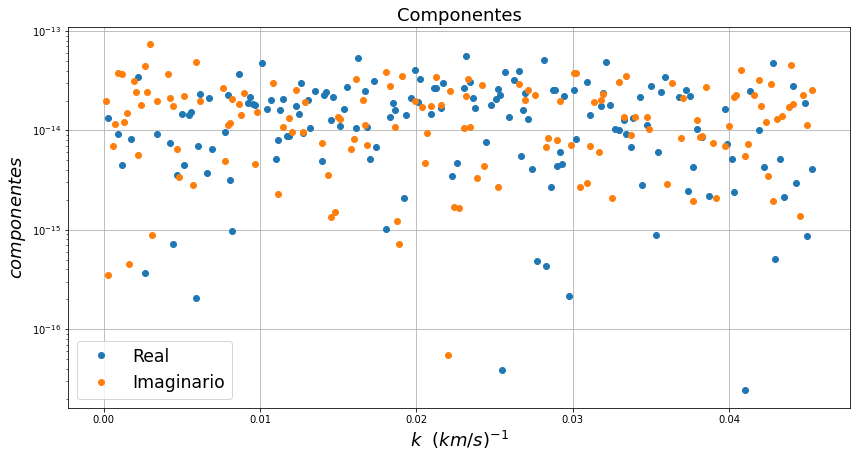

In [36]:
plt.figure(figsize=(14,7))
plt.title('Componentes',fontsize = 18)
plt.plot(k1d,Preal,'o', label = 'Real')
plt.plot(k1d,Pcomp,'o', label = 'Imaginario')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$componentes$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

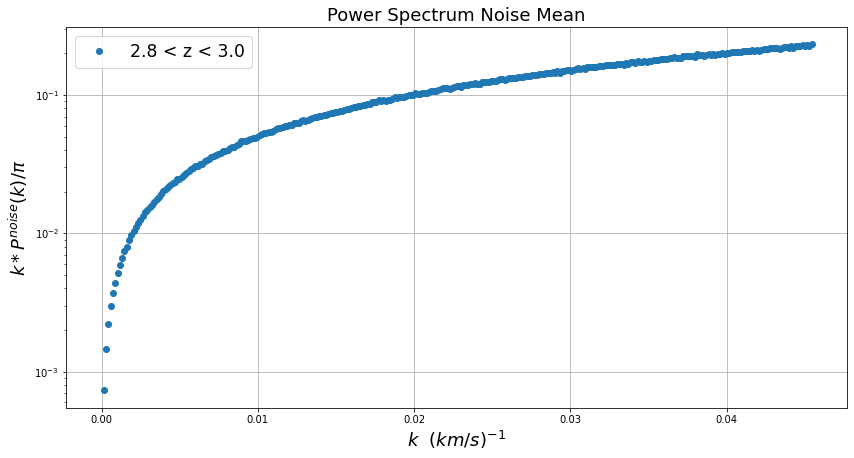

In [37]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Noise Mean',fontsize = 18)
plt.plot(k1d,k1d*Pk_noise_mean/np.pi,'o', label = '2.8 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{noise}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [38]:
def window(vel, reso, kvec):
    nb_bin_FFT = len(kvec)
    cor = np.ones(nb_bin_FFT)

    sinc = np.ones(nb_bin_FFT)
    sinc[kvec>0.] = sp.sin(kvec[kvec>0.]*vel/2.0)/(kvec[kvec>0.]*vel/2.0)

    cor *= sp.exp(-((kvec*reso)**2)/2.0)
    cor *= sinc
    Win = cor**2
    return Win

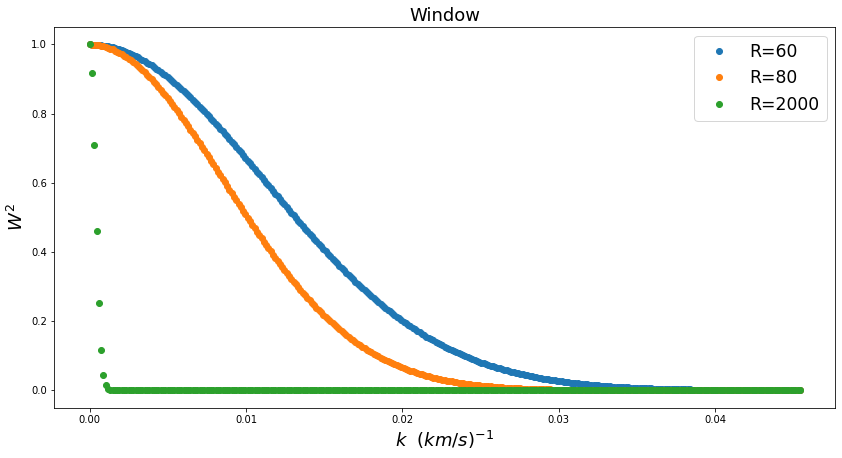

In [39]:
win1 = window(Dv,60,k1d)
win2 = window(Dv,80,k1d)
win3 = window(Dv,2000,k1d)

plt.figure(figsize=(14,7))
plt.title('Window',fontsize = 18)
plt.plot(k1d,win1,'o', label = 'R=60')
plt.plot(k1d,win2,'o', label = 'R=80')
plt.plot(k1d,win3,'o', label = 'R=2000')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
#plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$W^{2}$',fontsize = 18)
plt.legend(fontsize='xx-large')

In [40]:
Pk1DT = (Pkraw_mean - Pk_noise_mean)/win1
Pk1DT2 = (Pkraw_mean - Pk_noise_mean)/win2

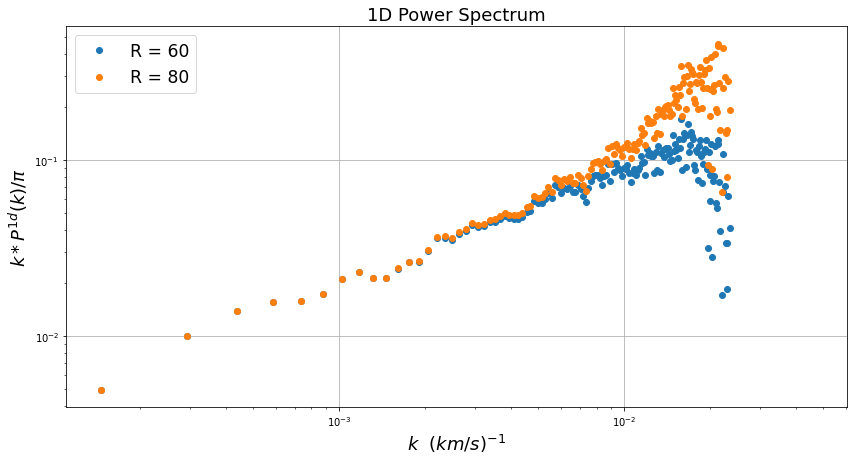

In [41]:
plt.figure(figsize=(14,7))
plt.title('1D Power Spectrum',fontsize = 18)
plt.plot(k1d,k1d*Pk1DT/np.pi,'o', label = 'R = 60')
plt.plot(k1d,k1d*Pk1DT2/np.pi,'o', label = 'R = 80')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{1d}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

Ya tenemos el 1D Power Spectrum, pero lo que pretendemos es cálcular el 1D Bisepctrum y para eso debemos ver como definirlo. Siguiendo [Peebles_1980](https://press.princeton.edu/books/paperback/9780691209838/the-large-scale-structure-of-the-universe), se tiene que el Bispectrum es:
\begin{equation}
\langle \delta_{1} \delta_{2} \delta_{3} \rangle = \delta_{D}(k_{1}+k_{2}+k_{3})B(k_{1},k_{2},k_{3}),
\end{equation}
donde la delta de Dirac es impuesto por la invarianza de tradución dictada por la homogeneidad estadística. Esto asegura que el los números de onda **k$_{i}$** deben de ser los tres lados de un triángulo cerrado para contribuir al bispectrum, es decir, se cumple que **k$_{1}$** + **k$_{2}$** + **k$_{3}$** = 0. Debido a la isotropía estadística solo hay dependencia del modulo del vector, es decir, $k_{i}$ = |**k$_{i}$**|.

Esta cantidad mide directamente la evolución no lineal de los campos de densidad y velocidad y, por lo tanto, es rica en información del régimen no lineal. Así,
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{1},k_{2}) = \langle \delta(k_{1}) \delta(k_{2}) \delta(-k_{1}-k_{2}) \rangle.
\end{equation}

Además del Power Spectrum sabemos que $\delta(k) = \delta^{*}(-k)$, en cuyo caso, $\delta^{*}(k) = \delta(-k)$.

Comencemos por poner las Deltas en $\delta(-k)$.

In [88]:
delmk = Pdelk.conjugate()     # Para las deltas de flujo
delmkiv = Dkiv.conjugate()    # Para las deltas de ruido

Ahora solo debo asegurarme de que se cumpla la restricción $k_{1} + k_{2} \leq k_{3}$

In [43]:
print('Notemos que')
print('{} < k < {},'.format(np.min(k1d), np.max(k1d).round(15)))

Notemos que
0.0 < k < 0.045437410252438,


```python
for i in range(k1d.size-1):
    for j in range(i,k1d.size):
        sumaa = k1d[i] + k1d[j]                      # Esto me dará el valor de k3 (salvo por el signo (-))
        #if sumaa.round(15) == k1d[i+j].round(15):
        if sumaa.round(15) <= np.max(k1d).round(15): # Aquí restrinjo a que k1 + k2 ≤ kmax3
            print(i,j)
            print(i+j)
```

entonces $k^{max}_{3} ≈ 0.045437 $

```python
def k3(kk, kdelta, kdeltan):
    delk3 = []
    for i in range(len(kdelta)):
        # Conciderar cada elemento excepto el último
        for m in range(len(kk)-1):
            # Comenzar a partir del m-ésimo elemento hasta el último
            for n in range(m, len(kk)):
                suma = kk[m] + kk[n]
                if suma.round(15) > np.max(kk).round(15): continue
                elif suma.round(15) <= np.max(kk).round(15):
                    Bk = kdelta[m] * kdelta[n] * kdeltan[m + n]           # se hace δ(k1)δ(k2)δ(−k1−k2)
```

Aunque la parte del código de arriba funcione, será complicado poder graficarlo. Así que dado que en los artículos ([Heavens_1997](https://watermark.silverchair.com/290-4-651.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqowggKmBgkqhkiG9w0BBwagggKXMIICkwIBADCCAowGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMspi1-66wE5yIbPwlAgEQgIICXeR8ZLbuplwpAKyEt5mAqHYnkIiNwI-Ko8kjmCI04gsd0ig-wK89j-YtsFzrxiRM9hbeT0lJu7SZZYKRsZMP1FCFFE2ycki8I-IhypAqHhcu9zsI_y237gMBRqinFfCIRA6APlGjc6o4FcQOURwBOErJmrCNnEA3-i4fveaf6g4NNuoJZDRQItTMqxdJTbcnLIfCu6tsY-hFsxdeEUZ1MBr8L6kSxqCOgyhmcJtKlvnUxgEhFkm1WQf882i7IJ9lHvrkTH34XJBO5t1Hq7-JEiStBeV609zO4freCFKd5At4jvX8xN4FIZQoeAiUoRw1xH41fPDrU34Z-kOxcVqzsKzLirAFuTUV23IN1dnpSBuyWd5is99_4vEtXl_FElVO_MkYDhFcIMMkI3iROMsegsun-iMhwsuL93E1HDnmp5y24PrlmLRS5iINCr8GjbZwU-eBjf6R4AyqrUtscDyFkl4urBc4uYTyWBWTGVVBVBgmJrjTv1jf3qxXe5XyhDZ0UV1BRmfjMLpL-o_n8A1WMA9b4ybP-wGy-4NQWljEkjhKs0RAfFVSTslXvHi4Ahl4yGWIru4dnGNIbLl2RRihioHL6Qf-D3mawHmd0vYrSmZNwAn20UZwhb6-cZGuuCrS94FxVkZnlsLii26TCyV3IXMpeHKDE0Go5RfKwK79SBYG0qy64p2T1kWYu5rbJz6ZQ3EF8xddQhPTaX5dIjbuGPBBjyO5NDkCmZ8ltpzr8fA-FMNHq3YeC-kLkyItRSmRfQ4d8hjI3fXO-kO_kLKrN3mTPf5Zv7ESdHolDlHd), [H.Marín_2015](https://arxiv.org/pdf/1407.5668.pdf)) se menciona que la mayor correlación solo se encuentra en triángulos con un vector **k** en común, esto es por los términos cruzados en la función de 6 puntos. Así que se tomarán los triángulos para los cuales k1 = k2, k1 = 2k2.

Entonces, para $k_{1} = k_{2}$
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{1}) = \langle \delta(k_{1})\delta(k_{1})\delta(-2k_{1})) \rangle = \langle \delta^{2}(k_{1}) \delta(-2k_{1}) \rangle.
\end{equation}

Y para $k_{1} = 2k_{2}$
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{2}) = \langle \delta(2k_{2}) \delta(k_{2}) \delta(-3k_{2}) \rangle 
\end{equation}

In [119]:
def Bispec(delvel,kbs, deltbs, deltbsn):
    lenforest = 2 * kbs.size - 1
    rr = np.arange(kbs.size)
    mask1 = (rr % 2 == 0)
    mask2 = (rr % 3 == 0)
    Bk1 = np.zeros((len(deltbs), kbs[mask1].size))
    Bk2 = np.zeros((len(deltbs), kbs[mask2].size))
    for i in range(len(Pdelk)):
        Bk11 = deltbs[i][:kbs[mask1].size]*deltbs[i][:kbs[mask1].size]*deltbsn[i][mask1] # se hace δ(k1)δ(k1)δ(−2k1)
        Bk1[i] = Bk11.real * (delvel**2) / (lenforest**2)                    
        Bk22 = deltbs[i][mask1][:kbs[mask2].size]*deltbs[i][:kbs[mask2].size]*deltbsn[i][mask2]# se hace δ(2k1)δ(k1)δ(−3k1)
        Bk2[i] = Bk22.real * (delvel**2) / (lenforest**2)

    BS1 = np.average(Bk1,axis=0)
    BS2 = np.average(Bk2,axis=0)
    kbs1 = kbs[:kbs[mask1].size]
    kbs2 = kbs[:kbs[mask2].size]
    return kbs1, kbs2, BS1, BS2

# Para $k_{1} = k_{2}$

In [120]:
kb1, kb2, Bsp1, Bsp2 = Bispec(Dv, k1d, Pdelk, delmk)

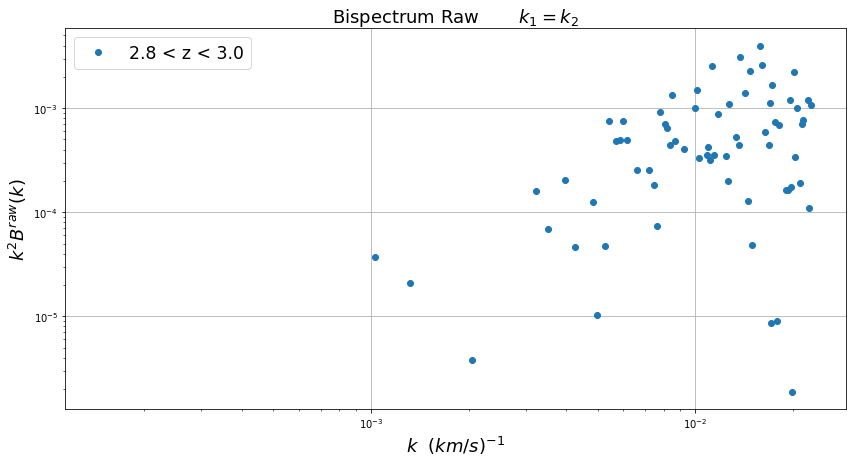

In [121]:
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(kb1,(kb1**2) * Bsp1,'o', label = '2.8 < z < 3.0')
plt.xscale('log')
plt.yscale('log')
#axhline(np.mean((k1d[:k1d[mask1].size]**2) * BS1), color = 'r', label = 'Average')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

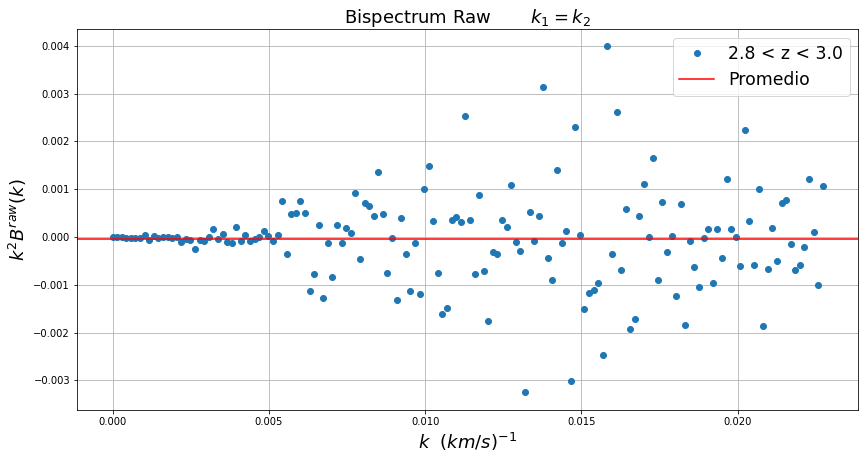

In [62]:
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(kb1,(kb1**2) * Bsp1,'o', label = '2.8 < z < 3.0')
#plt.xscale('log')
#plt.yscale('log')
axhline(np.mean((k1d[:k1d[mask1].size]**2) * BS1), color = 'r', label = 'Promedio')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [63]:
print('Promedio = ',np.mean((kb1**2) * Bsp1), ', para k1 = k2')

Promedio =  -3.800422017866905e-05 , para k1 = k2


# Para $k_{1} = 2k_{2}$

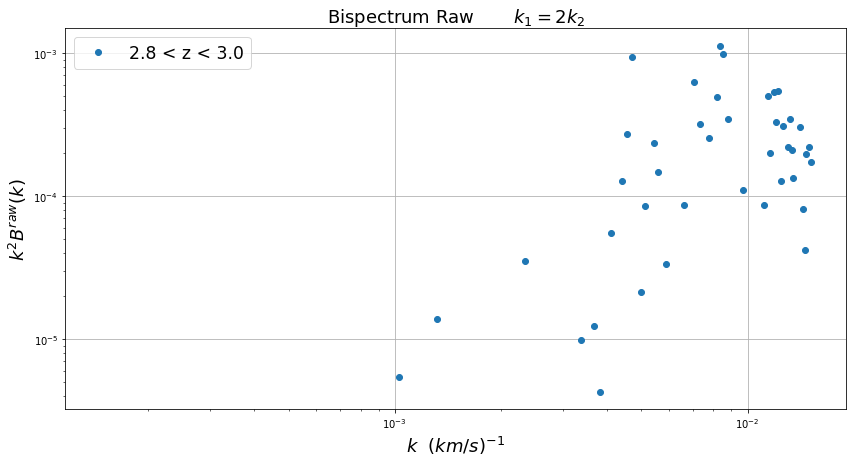

In [122]:
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = 2k_{2}$',fontsize = 18)
plt.plot(kb2,(kb2**2) * Bsp2,'o', label = '2.8 < z < 3.0')
plt.xscale('log')
plt.yscale('log')
#axhline(np.mean((k1d[:k1d[mask1].size]**2) * BS1), color = 'r', label = 'Average')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

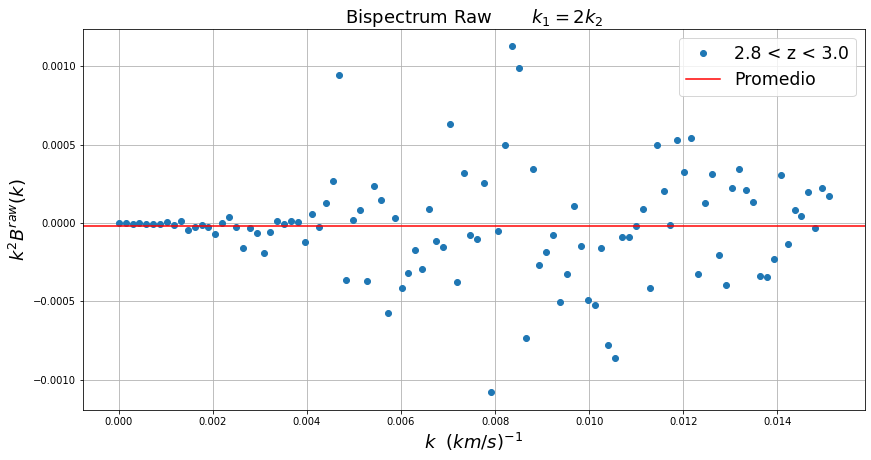

In [123]:
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = 2k_{2}$',fontsize = 18)
plt.plot(kb2,(kb2**2) * Bsp2,'o', label = '2.8 < z < 3.0')
#plt.xscale('log')
#plt.yscale('log')
axhline(np.mean((k1d[:k1d[mask2].size]**2) * BS2), color = 'r', label = 'Promedio')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [124]:
print('Promedio = ',np.mean((kb2**2) * Bsp2), ', para k1 = k2')

Promedio =  -2.071902839526405e-05 , para k1 = k2


### Para el ruido.

In [125]:
kbiv1, kbiv2, Bspiv1, Bspiv2 = Bispec(Dv, k1d, Dkiv, delmkiv)

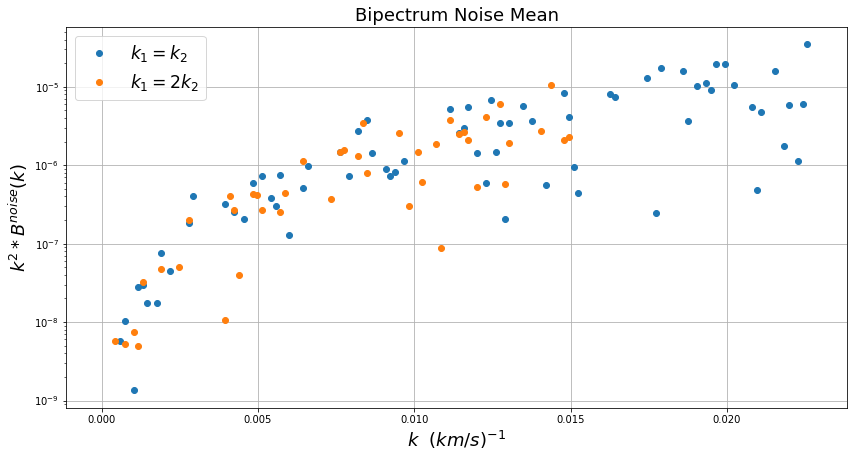

In [126]:
plt.figure(figsize=(14,7))
plt.title('Bipectrum Noise Mean',fontsize = 18)
plt.plot(kbiv1,(kbiv1**2) * Bspiv1,'o', label = '$k_{1} = k_{2}$')
plt.plot(kbiv2,(kbiv2**2) * Bspiv2,'o', label = '$k_{1} = 2k_{2}$')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}*B^{noise}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

# Para el 1D Bispectrum tomando en cuenta el ruido y la función ventana.

Vamos a definir el 1D Bispectrum de la siguiente manera:

\begin{equation}
B_{1D}(k_{1},k_{2},k_{3}) = \langle \dfrac{B^{raw}(k_{1},k_{2},k_{3}) - B^{noise}(k_{1},k_{2},k_{3})}{W^{2}(k,R,\Delta v)} \rangle,
\end{equation}

donde $W^{2}$ es la función venta que se ha usado de manera usual.

In [127]:
Bk1DT = (Bsp1 - Bspiv1)/win2[:156]       # Para k1 = k2
Bk1DT2 = (Bsp2 - Bspiv2)/win2[:104]      # Para k1 = 2k2

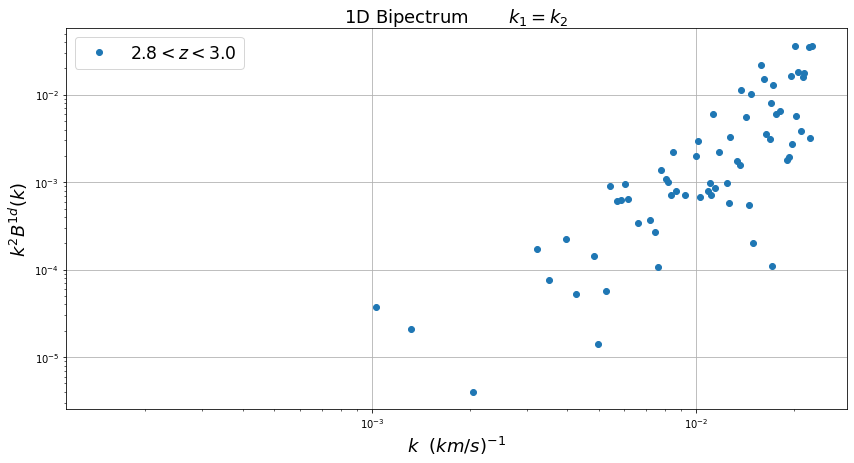

In [130]:
plt.figure(figsize=(14,7))
plt.title('1D Bipectrum       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(kb1,(kb1**2) * Bk1DT,'o', label = '$ 2.8 < z < 3.0$')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{1d}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

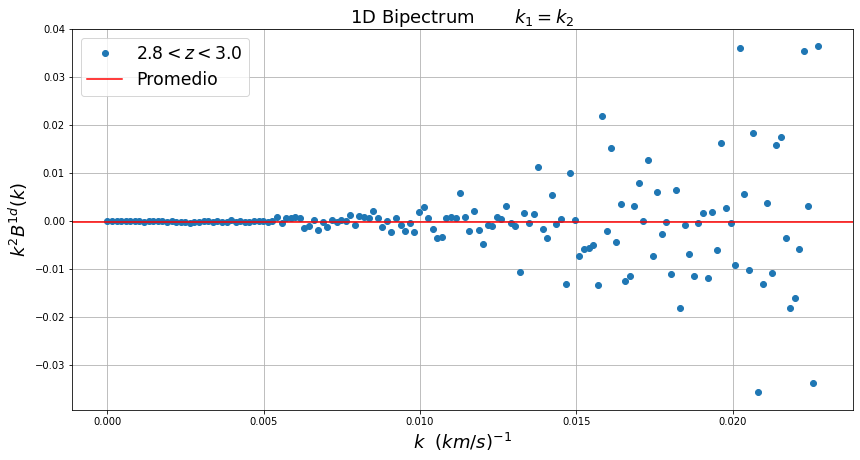

In [131]:
plt.figure(figsize=(14,7))
plt.title('1D Bipectrum       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(kb1,(kb1**2) * Bk1DT,'o', label = '$ 2.8 < z < 3.0$')
axhline(np.mean((kb1**2) * Bk1DT), color = 'r', label = 'Promedio')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{1d}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [134]:
print('promedio = ', np.mean((kb1**2) * Bk1DT), 'para k1 = k2')

promedio =  -0.00016539678242161272 para k1 = k2


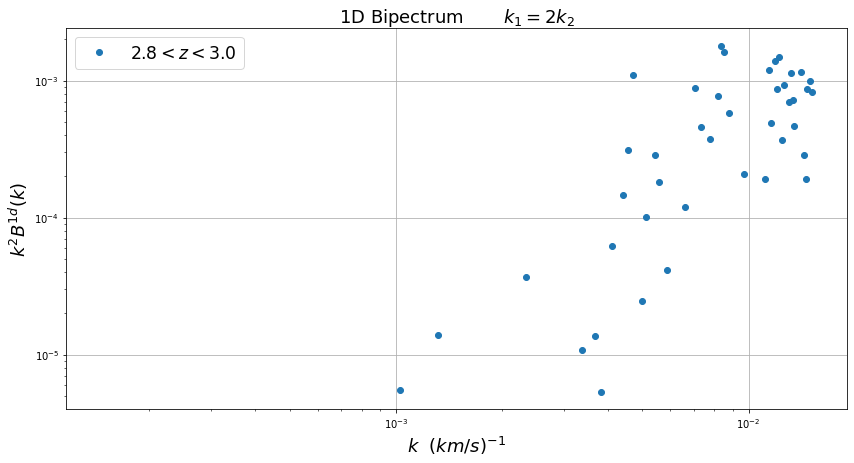

In [132]:
plt.figure(figsize=(14,7))
plt.title('1D Bipectrum       $k_{1} = 2k_{2}$',fontsize = 18)
plt.plot(kb2,(kb2**2) * Bk1DT2,'o', label = '$ 2.8 < z < 3.0$')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{1d}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

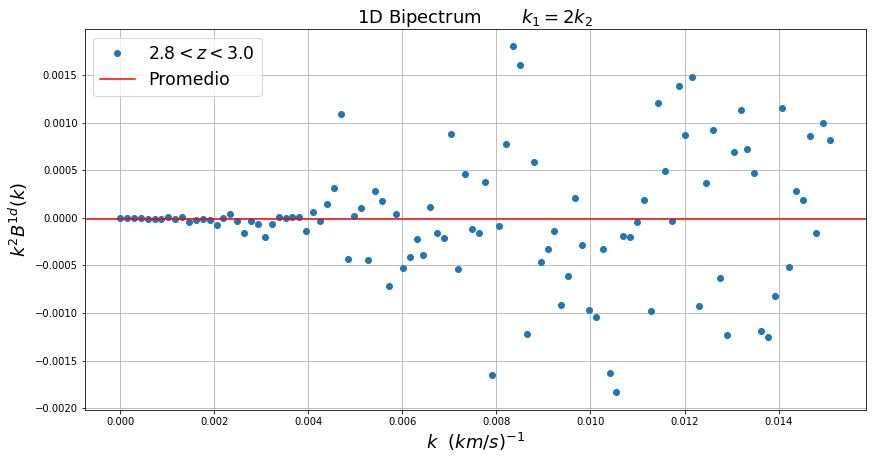

In [133]:
plt.figure(figsize=(14,7))
plt.title('1D Bipectrum       $k_{1} = 2k_{2}$',fontsize = 18)
plt.plot(kb2,(kb2**2) * Bk1DT2,'o', label = '$ 2.8 < z < 3.0$')
axhline(np.mean((kb2**2) * Bk1DT2), color = 'r', label = 'Promedio')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{1d}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [135]:
print('promedio = ', np.mean((kb2**2) * Bk1DT2), 'para k1 = 2 k2')

promedio =  -1.4244496034991807e-05 para k1 = 2 k2
